# Data cleaning

## Intro:

In this notebook, I will import the updated training features from notebook 1. I will then clean the training data and end by splitting the data into training, validation, and test sets (x and y).

Shoutout to these helpful scripts:

- https://www.kaggle.com/infinitewing/xgboost-without-outliers-lb-0-06463

In [85]:
import numpy as np
import pandas as pd
import timeit
# import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import category_encoders as ce

# from datetime import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

In [86]:
np.random.seed(1234)

In [232]:
# Read data from saved pickle files from notebook 1.
updated_properties = pd.read_pickle('Data/updated_properties')
train = pd.read_pickle('Data/train')

In [88]:
for c, dtype in zip(updated_properties.columns, updated_properties.dtypes):
    if dtype == np.float64:
        updated_properties[c] = updated_properties[c].astype(np.float32)

In [89]:
# updated_properties.info()
# We can see that changing to float32 reduces memory by 500MB

In [90]:
print(updated_properties.shape)

(2985217, 68)


For each house (or apartment, rental...), we have 67 features (68 minus parcelid), and only 4 come as object dtypes. Let's inspect these first.

## Handle object dtypes

In [91]:
obj_cols = []
for col in updated_properties.columns:
        # for each column, see if it is a object type
        if updated_properties[col].dtype == 'O':
            obj_cols.append(col)
            
unique_vals = {}
# for each object dtype, add unique values to labeled dictionary element
for col in updated_properties[obj_cols]:
    unique_vals[col]= (updated_properties[obj_cols][col].unique())

In [92]:
unique_vals

{'fireplaceflag': array([nan, True], dtype=object),
 'hashottuborspa': array([nan, True], dtype=object),
 'propertycountylandusecode': array(['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
        '010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214',
        '0101', nan, '070P', '0700', '1', '128', '0', '1112', '5050',
        '1110', '1118', '010E', '1111', '1129', '1420', '1222', '1128',
        '1310', '1117', '1333', '1116', '1410', '0104', '070D', '0108',
        '012C', '0400', '0103', '01DC', '0201', '010M', '030V', '0110',
        '010F', '010G', '010H', '0301', '0102', '020E', '020M', '0401',
        '0113', '0141', '122', '38', '135', '96', '71', '73', '34', '0209',
        '040G', '010L', '012E', '0111', '1720', '1014', '012D', '1213',
        '1201', '1321', '1444', '1421', '0140', '0123', '0133', '020G',
        '030G', '105', '0204', '010T', '0120', '1202', '121G', '010X',
        '020V', '880V', '1120', '0130', '0118', '01HE', '120G', '5060',
 

In [93]:
print(len(unique_vals['propertyzoningdesc']))

5639


Fairly standard....but the property zoning description variable has {{len(unique_vals['propertyzoningdesc'])}} different outcomes. This seems a bit excessive and holds us up when we try to do one-hot encoding. Let's try to trim it.

In [94]:
pd.DataFrame(updated_properties['propertyzoningdesc'].value_counts())[0:10]

,propertyzoningdesc
LAR1,275029
LAR3,67105
LARS,54859
LBR1N,52750
LAR2,48808
LARD1.5,39895
SCUR2,30459
LARD2,30377
TORR-LO,26632
LARA,26103


So most properties have code 'LAR1', and the distribution is heavily skewed right, with most zoning codes only appearing once.

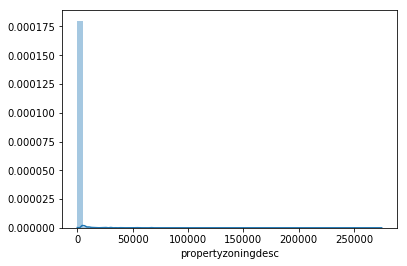

In [95]:
sns.distplot(pd.DataFrame(updated_properties['propertyzoningdesc'].value_counts().reset_index())['propertyzoningdesc'])

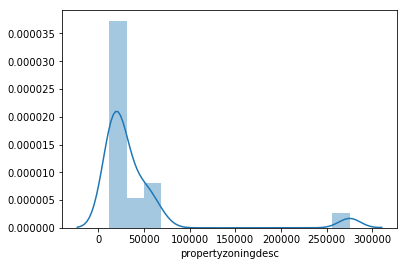

In [96]:
sns.distplot(pd.DataFrame(updated_properties['propertyzoningdesc'].value_counts().reset_index()[0:20])['propertyzoningdesc'])

Zoomed in to look at only 20 most populat zoning codes...you can see we have 1 zoning code that occurs 250k times and then most others in the top 20 occur less than 50 thousand times.

So where should we trim?

In [97]:
sum(pd.DataFrame(updated_properties['propertyzoningdesc'].value_counts())['propertyzoningdesc']>5000)

62

The code above shows that there are 62 different zoning types that have at least 5000 homes in the sample that fall in them. Let's draw an arbitrary line in the sand here. If a home has a zoning type that is not one of these 62, let's call it other.

In [98]:
# Find boolean. Return true if this propertyzoningdesc shows up >5000 in data. 
popular_codes = pd.DataFrame(updated_properties['propertyzoningdesc'].value_counts())['propertyzoningdesc']>5000

In [99]:
# Make df of index and number of times in properties df this zoningdesc shows up.
zoning_code_df = pd.DataFrame(updated_properties['propertyzoningdesc'].value_counts())[popular_codes].reset_index()
zoning_code_df.head(2)

,index,propertyzoningdesc
0,LAR1,275029
1,LAR3,67105


In [100]:
# Use pd.isin! 
# This resets propertyzoningdesc so that we only have top 62 zoning types, plus 'Other'.
updated_properties['propertyzoningdesc'] = np.where(updated_properties['propertyzoningdesc'].isin(set(zoning_code_df['index'])),updated_properties['propertyzoningdesc'],'Other')

In [101]:
updated_properties.head(5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,N-LivingAreaProp,N-ValueRatio,N-ValueProp,N-location,N-location-2,N-ExtraSpace,N-zip_count,N-TaxScore,N-Avg-structuretaxvaluedollarcnt,N-structuretaxvaluedollarcnt-2
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-84509640.0,-4.051377e+15,NaN,8496.0,NaN,375668.56250,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-84484936.0,-4.049921e+15,NaN,8496.0,NaN,375668.56250,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.157581,67.950089,0.853304,-84405272.0,-4.024158e+15,-9941.0,9437.0,2.939897e+10,145331.09375,4.234834e+11
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,0.673847,79.466148,0.975846,-84288344.0,-4.044496e+15,2453.0,7916.0,1.684069e+10,182727.84375,3.264363e+11
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,0.208647,75.716705,0.808511,-84191648.0,-4.048104e+15,6736.0,7725.0,2.481810e+09,182727.84375,3.755689e+10


So most of the object columns contain nan and one other value, like True or Y...'propertycountylandusecode' contains various categorical codes. This is all easy enough. If we use sklearn label encoder, we can convert each categrical response to a number...but this seems bad to do. We don't want a machine learning model to interpret the difference between landcode '010D' = 1 and '1210' = 4 as four times as much. This seems to be a mistake the label encoder method uses. 

XGB (the planned model here) takes only numeric [input](https://github.com/dmlc/xgboost/issues/95), so I think we should do [one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f), right?

Actually, with further research, it seems that one hot encoding can be too cumbersome. We actually are going to try binary encoding, since that seems to perform [best](http://www.kdnuggets.com/2015/12/beyond-one-hot-exploration-categorical-variables.html).

See: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

### Binary encode object vars:

So how do we binary encode something...the idea is that we can encode 2 categories with one variable (0 or 1) but we can encode 4 categories with two variables with each value slightly extended (0 0, 1 1, 0 1, 1 0). This is better than one hot encoding, where we would need 3 variables to represent 4 categories. 

We can handle a greater number of categories in this case while not making our data grow excessively wide. For instance, 8 categories would require 7 one hots, but only 3 binary variables (111, 110, 100, 000, 001, 011, 010, 101). This efficiency scales exponentially, in a way.

So let's try to implement this.

In [18]:
# updated_properties['propertycountylandusecode'].value_counts()

In [19]:
# Convert to string so we can convert to numbers.
updated_properties['propertycountylandusecode'] = updated_properties['propertycountylandusecode'].astype('str') 

In [102]:
le = preprocessing.LabelEncoder()
le.fit(updated_properties['propertycountylandusecode'].astype('str'))
x = le.transform(updated_properties['propertycountylandusecode'].astype('str')) 

In [103]:
# Check to see if this seems to have worked
pd.Series(x).value_counts()[0:4]

2      1153896
177     522145
3       247494
11      225410
dtype: int64

In [104]:
updated_properties['propertycountylandusecode'].value_counts()[0:4]

0100    1153896
122      522145
0101     247494
010C     225410
Name: propertycountylandusecode, dtype: int64

Great...so we can see above that, for example, the code '0100' was converted to the number 2. Similarly, the code '010C' was converted to the number 11. So now this variable just has different integers in place of where it originally had confusing codes. 

This is nice because we can represent these numbers with binary. Let's attempt:

In [105]:
print(len(pd.Series(x).value_counts()))

241


In [106]:
import category_encoders as ce

Since we have {{len(pd.Series(x).value_counts())}} unique values, we need to use binary 8 (2^8 = 256 < 241). So let's encode each number into 8 bits. We could do this manually, but the category encoder package handles this well:

In [212]:
properties3 = pd.read_pickle('Data/binarized_objects')

In [108]:
properties3.head()

,level_0,hashottuborspa_0,propertycountylandusecode_0,propertycountylandusecode_1,propertycountylandusecode_2,propertycountylandusecode_3,propertycountylandusecode_4,propertycountylandusecode_5,propertycountylandusecode_6,propertycountylandusecode_7,...,N-LivingAreaProp,N-ValueRatio,N-ValueProp,N-location,N-location-2,N-ExtraSpace,N-zip_count,N-TaxScore,N-Avg-structuretaxvaluedollarcnt,N-structuretaxvaluedollarcnt-2
0,0,NaN,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,-84509640.0,-4.051377e+15,NaN,8496.0,NaN,375668.56250,NaN
1,1,NaN,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,-84484936.0,-4.049921e+15,NaN,8496.0,NaN,375668.56250,NaN
2,2,NaN,0,0,0,0,0,0,1,0,...,1.157581,67.950089,0.853304,-84405272.0,-4.024158e+15,-9941.0,9437.0,2.939897e+10,145331.09375,4.234834e+11
3,3,NaN,0,0,0,0,0,0,1,0,...,0.673847,79.466148,0.975846,-84288344.0,-4.044496e+15,2453.0,7916.0,1.684069e+10,182727.84375,3.264363e+11
4,4,NaN,0,0,0,0,0,0,1,1,...,0.208647,75.716705,0.808511,-84191648.0,-4.048104e+15,6736.0,7725.0,2.481810e+09,182727.84375,3.755689e+10


In [109]:
# Working code to binarize object varibles. Commented out as I already ran
# and now can load locally saved pickle file (as above)


# start_time = timeit.default_timer()
# encoder = ce.BinaryEncoder()

# new_df2 = updated_properties
# new_df2 = new_df2.reset_index()
# for i, col in enumerate(new_df2[obj_cols]):
#     print(i+1, '/', len(obj_cols),': Starting to binarize column {}.'.format(col))
#     properties3 = encoder.fit_transform(new_df2, cols = col).reset_index()

# print('Done!')

# elapsed = timeit.default_timer() - start_time
# print('This took {} seconds to run.'.format(elapsed))

FYI, code above typically takes around 30 minutes to run on my 1.8GHZ processor, 8GB memory Macbook Air. This sucks, but whatever.

In [110]:
properties3.shape

(2985217, 82)

In [28]:
# properties3.to_pickle('binarized_objects')

In [111]:
# Check to make sure bad columns are gone:
import random
try: # check to see if key in obj_cols is still there
    random_column = random.choice(obj_cols)
    print('This time, we randomly chose to investigate if column \'{}\' is still here.'.format(random_column))
    properties3[random_column]
except KeyError:
    print('\nIt isn\'t, and we got the KeyError we wanted!')

This time, we randomly chose to investigate if column 'propertycountylandusecode' is still here.

It isn't, and we got the KeyError we wanted!


## Handle missing values


In [210]:
# NA fill with -1.

# for c in properties3.columns:
#     properties3[c]=properties3[c].fillna(-1)

## Handle categorical data coded as numeric

From reading the data dictionary, we see that several variables are coded with numeric responses, but thinking of them in a numeric way is fallacious. For example, 'HeatingOrSystemTypeID' has numeric responses 1-25...

In [116]:
properties3['heatingorsystemtypeid'].value_counts()

2.0     1156830
7.0      595453
6.0       27480
24.0      21107
20.0       3216
13.0       1342
18.0        586
1.0         262
14.0         41
10.0         39
12.0         25
11.0         16
21.0          3
19.0          1
Name: heatingorsystemtypeid, dtype: int64

In this case, a 2.0 indicates 'Central' heating, whereas 7.0 indicates 'Floor/Wall'. If we treat this as numeric, Floor/Wall heating is somehow interpreted as ~4x Central heating. We don't want our model to be searching for this sort of non-existent relationship. Fortunately, most of the quanitatively labelled categorical variables have 'id' in their title. Let's use regex to ferret them out.

Before we do so, let's note that the pooltypeid variables are just NAN or 1, indicating yes or no essentially. We can leave these as are and convert NAN to -1 later. 
- 'pooltypeid10'
- 'pooltypeid2'
- 'pooltypeid7'

Otherwise, it seems, too that things like the FIPS code are numeric but shouldn't be considered so. I am not sure how we should deal with them, but let's make a list for now of other problematic ones:
- 'fips'
- 'rawcensustractandblock'
- 'censustractandblock'
- 'regionidcounty'
- 'regionidcity'
- 'regionidzip'
- 'regionidneighborhood'

In [117]:
# Variables with id in the title:
id_variables1 = []
for col in properties3.columns:
    if re.search(r'id', col):
        id_variables1.append(col)
print(id_variables1)

['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid', 'typeconstructiontypeid']


Great, so we just need to take out pool variables and add in:
- 'fips'
- 'rawcensustractandblock'
- 'censustractandblock'
And we are good.

In [118]:
to_add = ['fips','rawcensustractandblock','censustractandblock']
id_variables_2 = id_variables1 + to_add
to_leave_out = ['pooltypeid10', 'pooltypeid2', 'pooltypeid7']
id_variables_3 = [item for item in id_variables_2 if item not in to_leave_out]

print(id_variables_3)

['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid', 'typeconstructiontypeid', 'fips', 'rawcensustractandblock', 'censustractandblock']


In [119]:
id_variables_3

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'heatingorsystemtypeid',
 'propertylandusetypeid',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'storytypeid',
 'typeconstructiontypeid',
 'fips',
 'rawcensustractandblock',
 'censustractandblock']

With these {{len(id_variables_3)}} variables, we need to NOT use their numeric inputs as numeric, and must instead convert to categorical. One hots is again the way to go, I think.

Before converting to one hot, I noted that the following variables have thousands of unique values, so converting to one hot will be really expensive computationally. As a result, let's just drop them.

In [211]:
also_to_leave_out = ['parcelid', 'regionidzip', 'rawcensustractandblock','censustractandblock']
id_variables_4 = [item for item in id_variables_3 if item not in also_to_leave_out]
id_variables_4

['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'heatingorsystemtypeid',
 'propertylandusetypeid',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'storytypeid',
 'typeconstructiontypeid',
 'fips']

In [213]:
# from category_encoders import *
# seemingly works with NAs
enc = BinaryEncoder(cols=id_variables_4).fit(properties3)
properties4 = enc.transform(properties3)

In [216]:
properties4.columns

Index(['airconditioningtypeid_0', 'airconditioningtypeid_1',
       'airconditioningtypeid_2', 'architecturalstyletypeid_0',
       'architecturalstyletypeid_1', 'architecturalstyletypeid_2',
       'architecturalstyletypeid_3', 'buildingclasstypeid_0',
       'buildingclasstypeid_1', 'buildingclasstypeid_2',
       ...
       'N-LivingAreaProp', 'N-ValueRatio', 'N-ValueProp', 'N-location',
       'N-location-2', 'N-ExtraSpace', 'N-zip_count', 'N-TaxScore',
       'N-Avg-structuretaxvaluedollarcnt', 'N-structuretaxvaluedollarcnt-2'],
      dtype='object', length=118)

In [223]:
properties4['architecturalstyletypeid_2'].value_counts()

0.0    5511
1.0     550
Name: architecturalstyletypeid_2, dtype: int64

In [228]:
properties4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 118 entries, airconditioningtypeid_0 to N-structuretaxvaluedollarcnt-2
dtypes: float32(49), float64(52), int64(17)
memory usage: 2.1 GB


In [229]:
properties4.to_csv('binarized_numerics')

In [230]:
properties4.shape

(2985217, 118)

## Subset (remove outliers...also just train on Oct for Oct...?)

In [ ]:


# drop out ouliers
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.4 ]
x_train=train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)

In [ ]:


print('After removing outliers:')     
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))


In [ ]:
# output.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%_m_%d_%H:%M:%S')), index=False)

# Works cited:

https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655/code